# ATMS 523 - Module 2
## `dask` workflows with `xarray`

In this notebook, we will examine a couple of workflows for using `dask` with `xarray`, which is a common flow for working with weather and climate data.

Let's fire up a `dask` client on our local machine.

In [2]:
import dask
import xarray as xr

# # 0) If you started a dask.distributed client earlier, close it
# try:
#     from dask.distributed import get_client
#     get_client().close()
# except Exception:
#     pass

# # 1) Force local threads scheduler (avoids pickling to workers)
# dask.config.set(scheduler="threads")


`xarray` is the most common way netCDF files are used to store and access weather and climate data, and it is a self describing format.  Other popular binary data formats are HDF and GRIB, but no worries, `xarray` can access those too (with some backend software that you can install).  

Earlier this module, you reviewed `xarray` usage - now let's extend this to some more advanced usage for processing large datasets!

---

There are several way to work with `dask` to process large datasets.  You can do an *en masse* processing, or you can do sequential processing where you feed a function to dask and it processes a task (think: more of like a for loop in python.  The former is best for a relatively small number of files (<1000), while the latter can be better for large numbers of files, due to limitations in how having many files open at once can impact performance on computers.  One thing to note that performance tuning in dask go hand in hand, especially if you need to tune the performance of a workflow for an operational setting where time is of the essence.

Let's try the *en masse* processing of some reanalysis data!

Here, we will do some processing of the European Center for Medium-range Weather Forecasts (ECMWF) ERA-5 project data.  We will grab the monthly mean data from the cloud using web links.  This allows you to access data in the cloud from a provider without downloading it to your local machine.  

Our provider will be the National Center for Atmospheric Research (NCAR) Geoscience Data Exchange [https://gdex.ucar.edu/], which provides a huge amount of data for analysis. You can go to their website to discover all their holdings!

---

Let's do some imports.

In [3]:
import xarray as xr
import pandas as pd
import numpy as np

Let's programmatically construct a URL for the files on the web server.  We need to match this pattern, and let python construct the URL based on that pattern.
```
https://osdf-data.gdex.ucar.edu/ncar/gdex/d633000/e5.oper.an.sfc/194112/e5.oper.an.sfc.128_034_sstk.ll025sc.1941120100_1941123123.nc
```
So, we need to dynamically generate the year and the timestamp.  We can use `pandas` to generate a `date_range`, and then create strings that match the pattern of the file.  We'll loop over each file and create that string for each file, appending each entry to a list.

In [4]:
base_url = 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/'
base_url2 = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2022-12', freq='YS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)



List all of the files we'll access:

In [5]:
file_list

['https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1979/e5.moda.an.sfc.128_034_sstk.ll025sc.1979010100_1979120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1980/e5.moda.an.sfc.128_034_sstk.ll025sc.1980010100_1980120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1981/e5.moda.an.sfc.128_034_sstk.ll025sc.1981010100_1981120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1982/e5.moda.an.sfc.128_034_sstk.ll025sc.1982010100_1982120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1983/e5.moda.an.sfc.128_034_sstk.ll025sc.1983010100_1983120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1984/e5.moda.an.sfc.128_034_sstk.ll025sc.1984010100_1984120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.an.sfc/1985/e5.moda.an.sfc.128_034_sstk.ll025sc.1985010100_1985120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.

Now we will just pass this list to `xarray` and it will retrieve the file metadata - building an `xarray` DataSet in the process.

In [6]:
#cached = [f"simplecache::{u}" for u in file_list]
ds = xr.open_mfdataset(
#    cached,
    file_list,
    engine="h5netcdf",         # or "h5netcdf"
    combine="by_coords",
    chunks={"time": 12},      # modest time chunks
    parallel=False,           # <- important: don't delay opens
  #  backend_kwargs={"storage_options": {"simplecache": {"cache_storage": "./_gdex_cache"}}},
)

Let's take a look at our object.

In [7]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 528, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2022-12-01
Data variables:
    SSTK       (time, latitude, longitude) float32 2GB dask.array<chunksize=(12, 389, 776), meta=np.ndarray>
    utc_date   (time) int32 2kB dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon Nov 11 07:46:57 MST 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Nov 11 07:46:58 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

OK, let's calculate an El Niño-Southern Oscillation index from the ERA-5 sea surface temperature field (`SSTK` variable).  Specifically, we'll calculate the Niño 3.4 index, which is a 5-month running mean of the SST anomalies (here from the 1981-2010 mean) within the box from 5°N to 5°S latitude and 170°W to 120°W longitude (we do this via slicing; note the order we provide as the order has to follow the order of the dataset for the slicing).  We will use `xarray` to calculate the smoothed time series as well as the long term mean. 

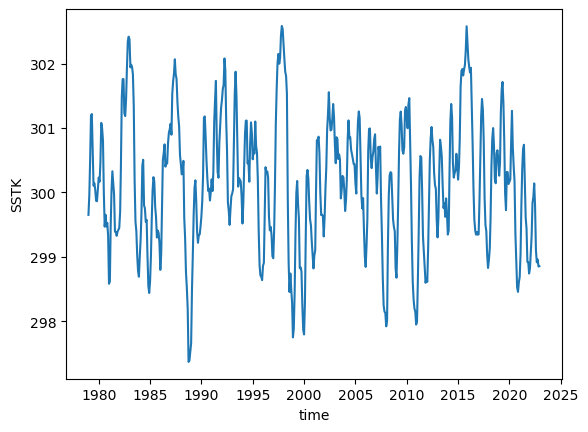

In [10]:
# Do the slicing and take the mean over the region (latitude + longitude).  This data covers the whole period of record.

ds_sub = ds['SSTK'].sel(latitude=slice(5,-5),longitude=slice(360-170,360-120)).mean(dim=['latitude','longitude'])

# visualize
ds_sub.compute().plot()

OK! We have the raw data, and it is a timeseries because we took a mean over the spatial dimensions (latitude and longitude).  Let's take a mean over 30 years to calculate a climatology over the period, and then use that to calculate the anomaly at each time relative to the climatology.

In [11]:
# Extract the long term mean over the 1981-2010 period.

mean_1981_2010 = ds_sub.sel(time=slice('1981-1-1','2010-12-31')).mean()


Now, lets calculate the departure from climatology by subtracting the long term mean, run the computation, and plot it!

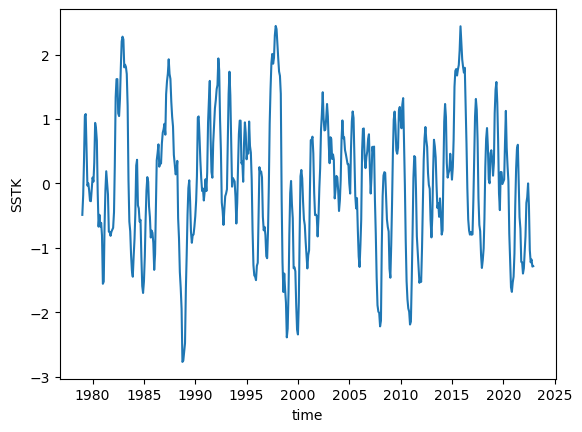

In [13]:
(ds_sub - mean_1981_2010).compute().plot()

Now, let's smooth the time series to make it more interpretable by adding a 5 month rolling mean.

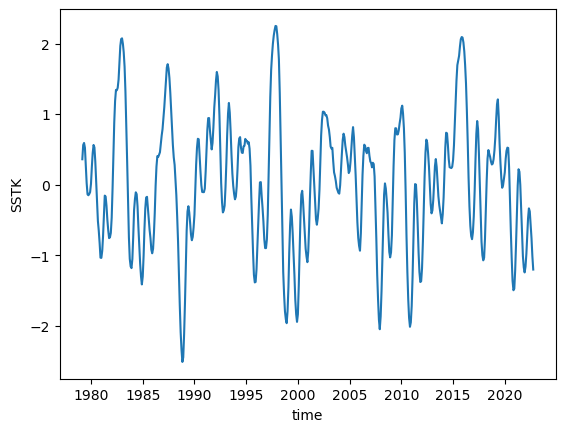

In [15]:
(ds_sub.rolling(time=5, center=True).mean() - mean_1981_2010).plot()

Now you know how to load data from a web server if you can generate a bunch of links matching a pattern.